In [1]:
import tensorflow as tf

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228818944/228813984 [==============================] - 115s 1us/step
/home/john/.keras/datasets/flower_photos


In [4]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [5]:
all_image_paths[:10]

['/home/john/.keras/datasets/flower_photos/tulips/7166646966_41d83cd703.jpg',
 '/home/john/.keras/datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg',
 '/home/john/.keras/datasets/flower_photos/dandelion/2294126841_e478564e77_n.jpg',
 '/home/john/.keras/datasets/flower_photos/dandelion/16242239484_51286673af.jpg',
 '/home/john/.keras/datasets/flower_photos/sunflowers/15054865768_2cc87ac9d4_m.jpg',
 '/home/john/.keras/datasets/flower_photos/dandelion/2634665077_597910235f_m.jpg',
 '/home/john/.keras/datasets/flower_photos/tulips/10163955604_ae0b830975_n.jpg',
 '/home/john/.keras/datasets/flower_photos/sunflowers/21984860006_20dfacea1c_m.jpg',
 '/home/john/.keras/datasets/flower_photos/dandelion/4598938531_9749b3b56a.jpg',
 '/home/john/.keras/datasets/flower_photos/sunflowers/4933824012_8cbfe606f6.jpg']

In [6]:
import os
attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

In [7]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])

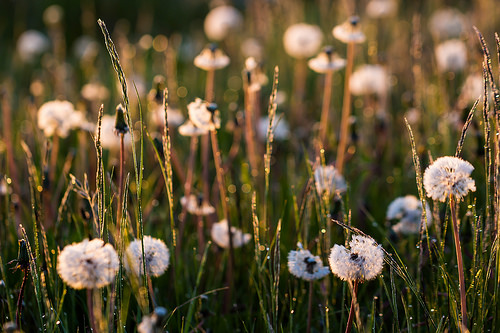

Image (CC BY 2.0)  by Susanne Nilsson



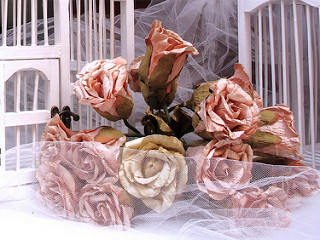

Image (CC BY 2.0)  by jacinta lluch valero



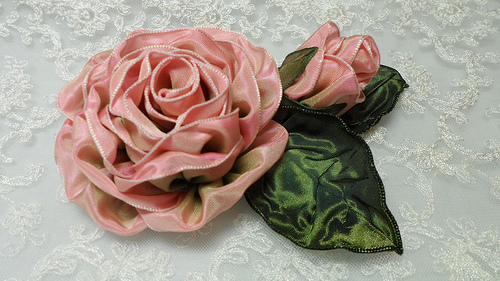

Image (CC BY 2.0)  by lambsandivydesigns.com



In [8]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print(caption_image(image_path))
    print()

In [9]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [10]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [11]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [4, 0, 1, 1, 3, 1, 4, 3, 1, 3]


In [12]:
img_path = all_image_paths[0]
img_path

'/home/john/.keras/datasets/flower_photos/tulips/7166646966_41d83cd703.jpg'

In [13]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\...


In [14]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(333, 500, 3)
<dtype: 'uint8'>


In [15]:
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


In [16]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range

    return image

In [17]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [18]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()

In [19]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [20]:
print(path_ds)

<TensorSliceDataset shapes: (), types: tf.string>


In [21]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

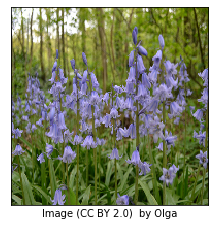

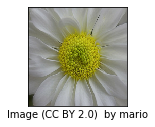

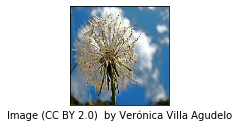

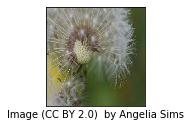

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
      plt.subplot(2,2,n+1)
      plt.imshow(image)
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      plt.xlabel(caption_image(all_image_paths[n]))
      plt.show()

In [23]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [24]:
for label in label_ds.take(10):
    print(label_names[label.numpy()])

tulips
daisy
dandelion
dandelion
sunflowers
dandelion
tulips
sunflowers
dandelion
sunflowers


In [25]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [26]:
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [27]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [30]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [31]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

9412608/9406464 [==============================] - 10s 1us/step


In [32]:
def change_range(image,label):
    return 2*image-1, label

keras_ds = ds.map(change_range)

In [33]:
image_batch, label_batch = next(iter(keras_ds))
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


In [34]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names), activation = 'softmax')])

In [35]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.0035298222
max logit: 0.73040503

Shape: (32, 5)


In [39]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [37]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

115.0

In [41]:
model.fit(ds, epochs=1, steps_per_epoch=115)

Train for 115 steps
115/115 [==============================] - 122s 1s/step - loss: 0.7732 - accuracy: 0.7038
